# Section 5.2: Real World Example with EUROSTOXX 50

First, include the necessary functions.
The linear programming solver requires the gurobi package!

In [1]:
library('MASS')
source(file="functions.r")

Warning message:
"package 'linprog' was built under R version 3.6.2"Loading required package: lpSolve
Warning message:
"package 'lpSolve' was built under R version 3.6.2"Warning message:
"package 'gurobi' was built under R version 3.6.2"Loading required package: slam
Warning message:
"package 'slam' was built under R version 3.6.2"

First load data of the EUROSTOXX 50, (CSV File not provided in this github repository)

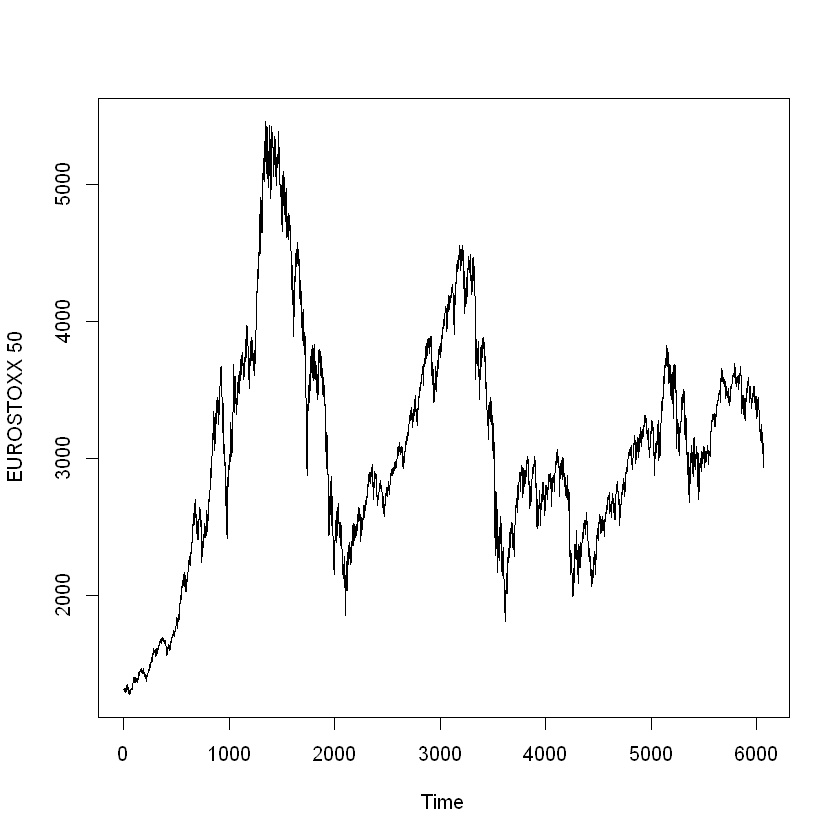

In [2]:
# Reading Data, Data can be found e.g. at Yahoo Finance
stoxx<-read.csv("^STOXX50E.csv",sep=",",header=T, as.is=T, stringsAsFactors = T)$Close
# Loading Dates
stoxx_dates<-read.csv("^STOXX50E.csv",sep=",",header=T,as.is=T, stringsAsFactors = T)$Date
# Cleaning Data
stoxx_dates<-stoxx_dates[stoxx!="null"]
stoxx<-stoxx[stoxx!="null"]

# 1st January 1995 - 30 Dezember 2018

stoxx_dates<-(stoxx_dates[2088:(length(stoxx)-79)])
stoxx<-(stoxx[2088:(length(stoxx)-79)])
stoxx<-as.numeric(stoxx)

#Plot
plot(1:length(stoxx),stoxx,type="l",xlab="Time", ylab="EUROSTOXX 50",lwd=1)

We estimate the empirical distributions of the 11-day return and the 21-day return

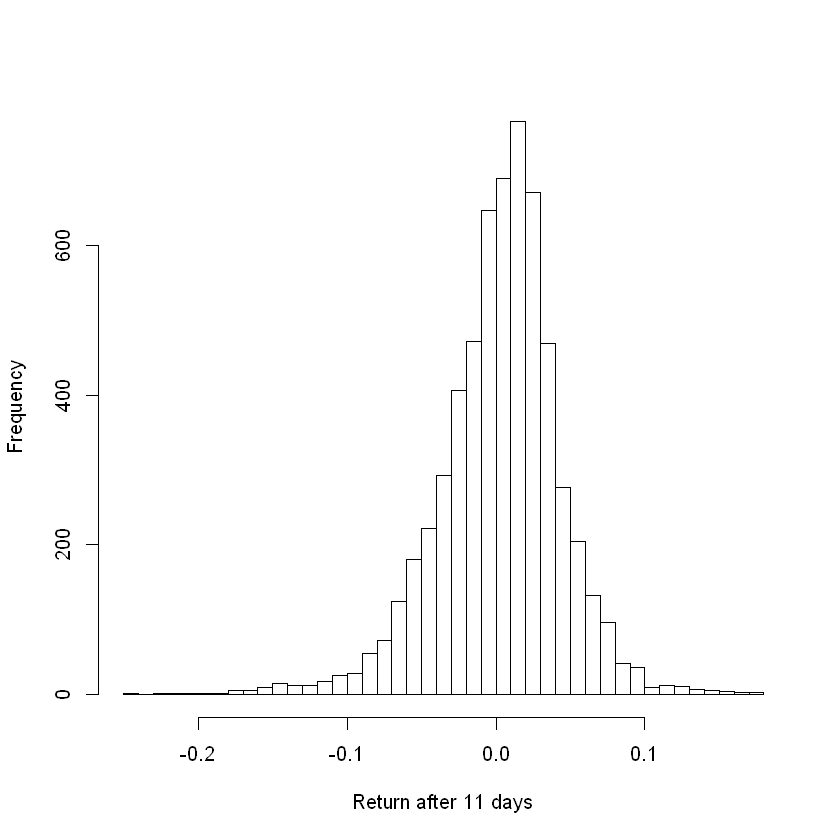

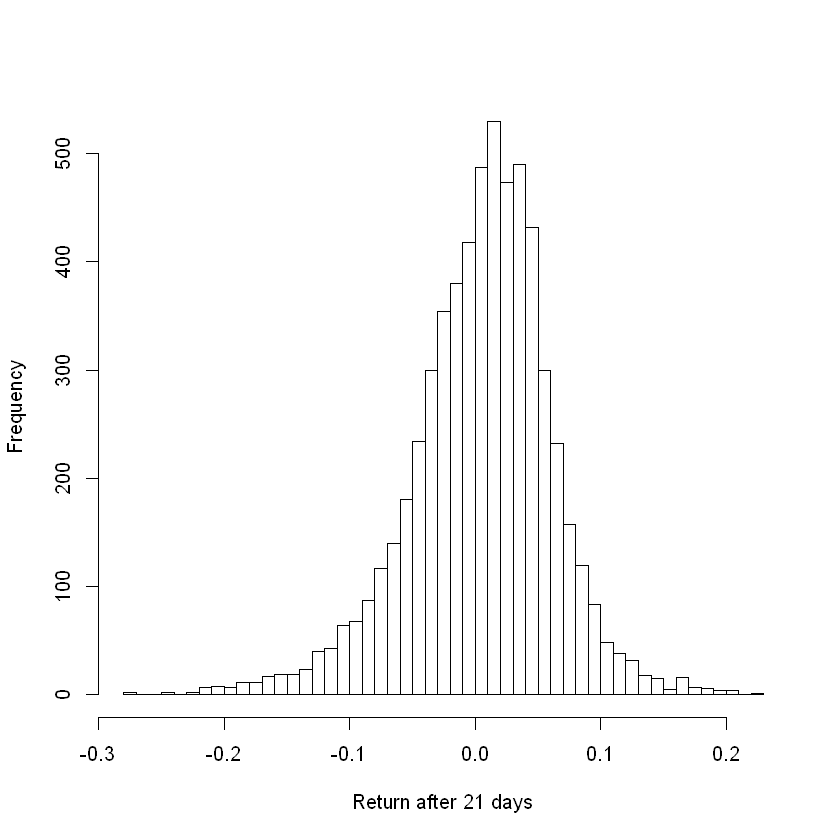

In [3]:
###### Saving Data ########
triple<-matrix(0,3,length(stoxx)-21)
for(i in 1:(length(stoxx)-21)){
  triple[1,i]<-stoxx[i]/stoxx[i]
  triple[2,i]<-(stoxx[i+11]-stoxx[i])/stoxx[i]   # 11-Tages Returns
  triple[3,i]<-(stoxx[i+21]-stoxx[i])/stoxx[i]   # 21-Tages Returns
}

### Plotting histograms of Returns######
hist(triple[2,],breaks=50,xlab="Return after 11 days",main = "")
hist(triple[3,],breaks=50,xlab="Return after 21 days",main = "")

We estimate the joint distribution of 11-day return and 21-day return (Normal Kernel)

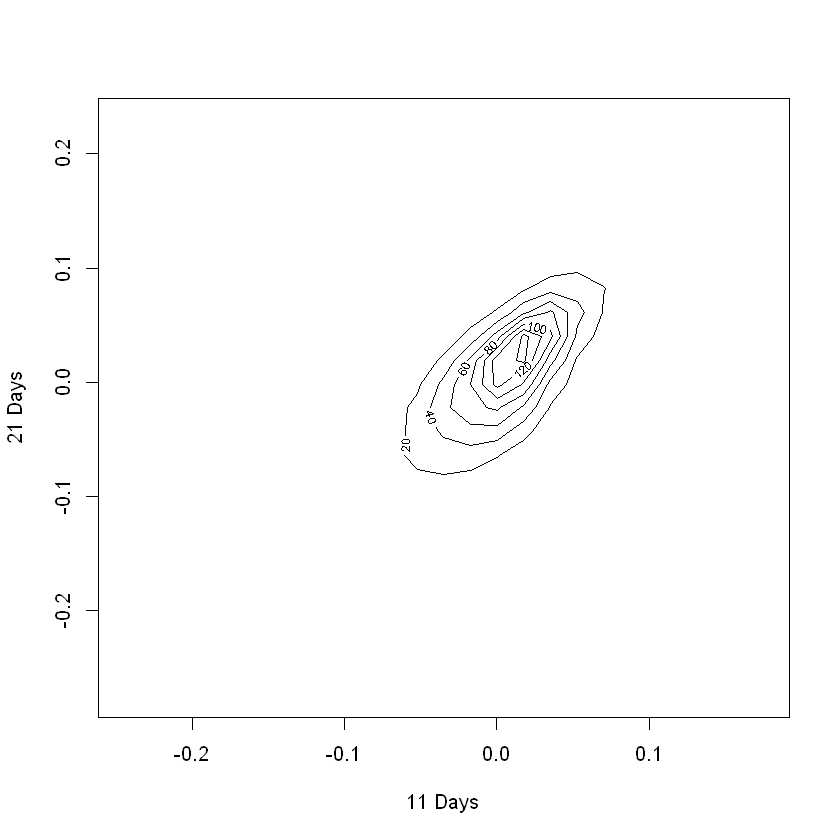

In [4]:
# Two dimensional Kernel Density Estimation 
f1<-kde2d(triple[2,], triple[3,],  n = 25, lims = c(range(triple[2,]), range(triple[3,])))
contour(f1, xlab = "11 Days", ylab = "21 Days" )

Definition of functions for the kernel estimation and for the computation of the profit of the strategy

In [5]:
# Function for the restriced estimation of the density
kernel_estimation<-function(last_days=60,today=61,nn=25,h_factor=1){
  h<-c(bandwidth.nrd(triple[2,(today-last_days-21):(today-21)]),bandwidth.nrd(triple[3,(today-last_days-21):(today-21)]))
  {
    k<-kde2d(triple[2,(today-last_days-21):(today-21)], triple[3,(today-last_days-21):(today-21)],n=nn,h=h_factor*h, 
             lims = c(range(triple[2,]), range(triple[3,])))
  }
  return(k)
}

# Define the Function returning the success of a strategy
stat_arb_success<-function(begin=13,end=286,m=50,N=5,est_length_days=21,h_from=0.9,h_until=1.1,trading_limit=1){
  t_2=1/12 # 21 days ~ 1/12 of the year
  t_1=1/24 # 11 days ~ 1/24 of the year
  f<-0
  success<-NULL
  # Loop over all months:
  for(month in begin:end){
    # Calculation of the trading days
    day_begin<-round(month*(length(stoxx)/(288)),0)+1
    day_end<-round((month+1)*(length(stoxx)/(288)),0)
    day_intermediate<-round(0.5*(day_begin+day_end),0)
    ### Setting S_0 to the current value
    S_0<-stoxx[day_begin]
    
    # Assigning Probabilities
    prob_set<-array(0,dim=c(N,m,m))
    
    # Discrete Values
    x<-matrix(0,N,m)
    y<-matrix(0,N,m)
    h<-seq(h_from,h_until,length=N)
    
    for(i in 1:N){ # Back Transformation: Returns -> Stock Values.
      return_values<-kernel_estimation(last_days=est_length_days,today=(day_begin),m,h_factor=h[i])
      x[i,]<-return_values$'x'*stoxx[day_begin-21]+stoxx[day_begin-21]
      y[i,]<-return_values$'y'*stoxx[day_begin-21]+stoxx[day_begin-21]
      }
    
    
    # Probabilities
    for(i in 1:N){
      for(j in 1:m){
        for(k in 1:m){
          prob_set[i,j,k]<-kernel_estimation(last_days=est_length_days,today=(day_begin),m,h_factor=h[i])$z[j,k]
        }
      }
      # Normalising
      prob_set[i,,]<-prob_set[i,,]/sum(prob_set[i,,])
    }
    # Computation of the Bounds
    upper_bound<-super_rep_robust(x,y,prob_set,func=function(x,y){0},stat_arb=T,lower=F,S_0,limit=trading_limit)
    Delta_0_upper<-upper_bound$Delta_0
    Delta_1_upper<-splinefun(upper_bound$x,upper_bound$Delta_1,method="fmm")
    
    ## success
    success<-c(success,Delta_0_upper*(stoxx[day_intermediate]-S_0)+Delta_1_upper(stoxx[day_intermediate])*(stoxx[day_end]-stoxx[day_intermediate]))
    f<-f+success[length(success)]
  }
  return(list(Gain=f,Best=round(max(success),2),
              Worst=round(min(success),2),Average=round(f/(end-begin+1),2),
              loss_perc=round(100*sum(success<0)/length(success),2),
              gains_perc=round(100*sum(success>0)/length(success),2)))
}

We compute the success for statistical arbitrage strategies with uncertainty in the bandwidth for different lookback periods of the density estimation

$\textbf{This computation may take a lot of time!!!}$ - To speed up the computation: Reduce Nr. of discretization points or the length of the considered days in the sequence

[1] 11
[1] 13.02273
[1] 15.04545
[1] 17.06818
[1] 19.09091
[1] 21.11364
[1] 23.13636
[1] 25.15909
[1] 27.18182
[1] 29.20455
[1] 31.22727
[1] 33.25
[1] 35.27273
[1] 37.29545
[1] 39.31818
[1] 41.34091
[1] 43.36364
[1] 45.38636
[1] 47.40909
[1] 49.43182
[1] 51.45455
[1] 53.47727
[1] 55.5
[1] 57.52273
[1] 59.54545
[1] 61.56818
[1] 63.59091
[1] 65.61364
[1] 67.63636
[1] 69.65909
[1] 71.68182
[1] 73.70455
[1] 75.72727
[1] 77.75
[1] 79.77273
[1] 81.79545
[1] 83.81818
[1] 85.84091
[1] 87.86364
[1] 89.88636
[1] 91.90909
[1] 93.93182
[1] 95.95455
[1] 97.97727
[1] 100


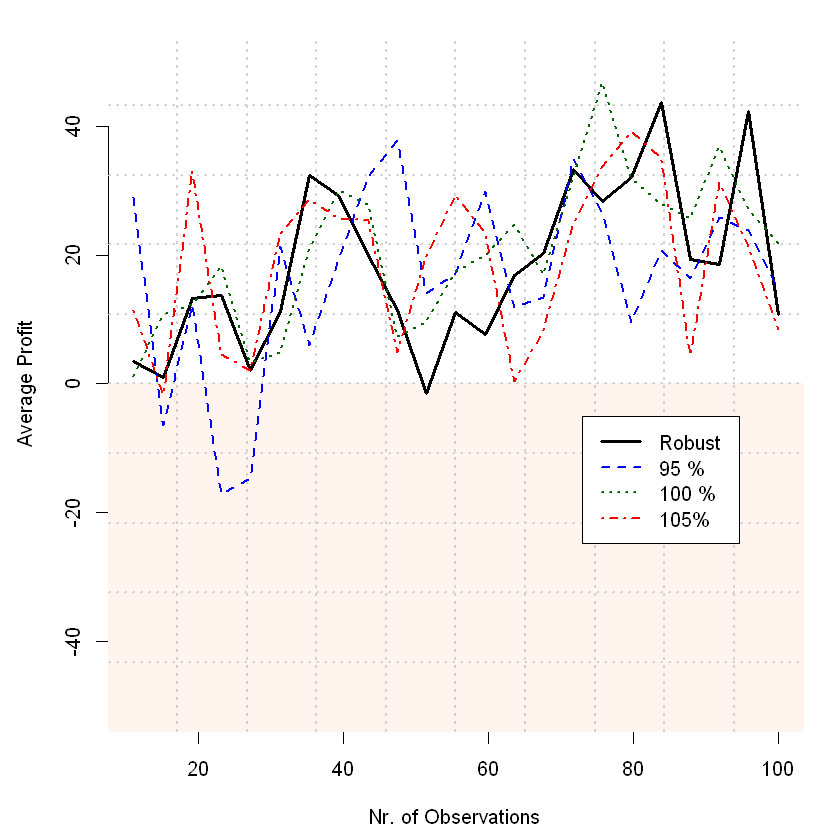

In [6]:
discretization_points = 50

h2 = 0.95
h3 = 1
h4 = 1.05


## Plotting in dependence of Estimation Length
avg_gain<-NULL
avg_gain_small_h_2<-NULL
avg_gain_small_h_3<-NULL
avg_gain_small_h_4<-NULL



days_sequence<-seq(11,100,length=45) # with length = 90 we get all, Takes a lot of time!!!!!!!!!

for(days in days_sequence){
  avg_gain<-c(avg_gain,stat_arb_success(begin=229,end = 286,m=discretization_points,h_from=h2,h_until=h4,N=5,est_length_days=days)$Average)
  avg_gain_small_h_2<-c(avg_gain_small_h_2,stat_arb_success(begin=229,end = 286,m=discretization_points,h_from=h2,h_until=h2,N=2,est_length_days=days)$Average)
  avg_gain_small_h_3<-c(avg_gain_small_h_3,stat_arb_success(begin=229,end = 286,m=discretization_points,h_from=h3,h_until=h3,N=2,est_length_days=days)$Average)
  avg_gain_small_h_4<-c(avg_gain_small_h_4,stat_arb_success(begin=229,end = 286,m=discretization_points,h_from=h4,h_until=h4,N=2,est_length_days=days)$Average)
  # Print Progress
  print(days/days_sequence[length(days_sequence)]*100)
}

# PLOT
par(mfrow=c(1,1))
par(mar=c(4.5, 4.5,1.5, 1.5))
plot(0,0,xlab="Nr. of Observations",ylab="Average Profit",xlim=c(11,100),ylim=c(-50,50),bty="n")
polygon(c(7.5,110,110,7.5),c(0,0,-80,-80),border = NA,col= "seashell" )
grid(10, 10, lwd = 2) # grid only in y-direction
lines(days_sequence[2*(1:45)-1],avg_gain[2*(1:45)-1],type="l",lwd=2.5)
lines(days_sequence[2*(1:45)-1],avg_gain_small_h_2[2*(1:45)-1],lwd=2,lty=2,col="blue")
lines(days_sequence[2*(1:45)-1],avg_gain_small_h_3[2*(1:45)-1],lwd=2,lty=3,col="darkgreen")
lines(days_sequence[2*(1:45)-1],avg_gain_small_h_4[2*(1:45)-1],lwd=2,lty=4,col="red")


legend(73, -5, c("Robust","95 % ","100 % ","105%"),col=c("black","blue","darkgreen","red"),lty=c(1,2,3,4),lwd=c(2.5,2,2,2))